###Install required libraries

In [ ]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=58856989dd5878271032db8ca78c67cc1d4ef4a70547e63212e0a46c62279b4d
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


##Training the models GCN, Graphsage and GAT for Cora dataset

Number of nodes in validation set of cora dataset:  1000

******************GCN MODEL*********************
Epoch 1. Loss: 1.9518. Validation accuracy: 0.4080. Test accuracy: 0.4680
Epoch 2. Loss: 1.8108. Validation accuracy: 0.5420. Test accuracy: 0.5620
Epoch 3. Loss: 1.6454. Validation accuracy: 0.5500. Test accuracy: 0.5870
Epoch 4. Loss: 1.4683. Validation accuracy: 0.5640. Test accuracy: 0.5840
Epoch 5. Loss: 1.2988. Validation accuracy: 0.5860. Test accuracy: 0.5990
Epoch 6. Loss: 1.1400. Validation accuracy: 0.6160. Test accuracy: 0.6230
Epoch 7. Loss: 0.9909. Validation accuracy: 0.6620. Test accuracy: 0.6680
Epoch 8. Loss: 0.8546. Validation accuracy: 0.7040. Test accuracy: 0.7200
Epoch 9. Loss: 0.7325. Validation accuracy: 0.7340. Test accuracy: 0.7500
Epoch 10. Loss: 0.6248. Validation accuracy: 0.7440. Test accuracy: 0.7710
Epoch 11. Loss: 0.5305. Validation accuracy: 0.7540. Test accuracy: 0.7820
Epoch 12. Loss: 0.4483. Validation accuracy: 0.7640. Test accuracy: 0.7920
Ep

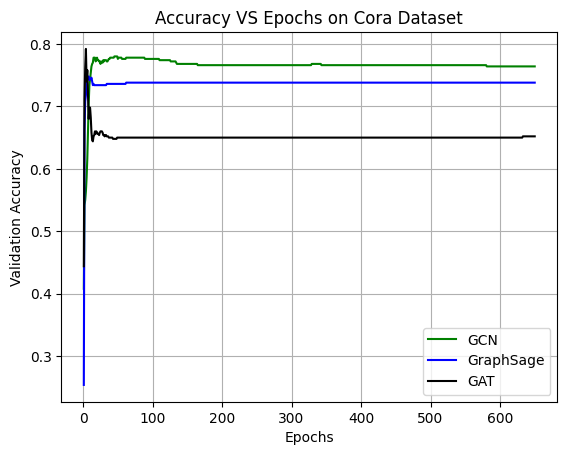

In [ ]:
import argparse
import torch
from sklearn.metrics import classification_report
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.nn as pyg_nn
from matplotlib import pyplot as plt
import models
import utils
import os

import sys
sys.argv=['']
del sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# get the device to run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def arg_parse():
    parser = argparse.ArgumentParser(description='GNN arguments.')
    utils.parse_optimizer(parser)

    parser.add_argument('--model_type', type=str, help='Type of GNN model.')
    parser.add_argument('--batch_size', type=int, help='Training batch size')
    parser.add_argument('--num_layers', type=int, help='Number of graph conv layers')
    parser.add_argument('--hidden_dim', type=int, help='Training hidden size')
    parser.add_argument('--dropout', type=float, help='Dropout rate')
    parser.add_argument('--epochs', type=int, help='Number of training epochs')
    parser.add_argument('--dataset', type=str, help='Dataset')

    parser.set_defaults(
        model_type='GCN',
        dataset='cora',
        num_layers=2,
        batch_size=32,
        hidden_dim=16,
        dropout=0.5,
        epochs=200,
        opt='adam',  # opt_parser
        opt_scheduler='none',
        weight_decay=0,
        lr=0.01)

    return parser.parse_args()


def train(dataset, task, args):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=args.batch_size, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=args.batch_size, shuffle=True)
    elif task == 'node':
        test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    else:
        raise RuntimeError('Unknown task')

    # build model
    model = models.GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args, task=task)
    model.to(device)
    scheduler, opt = utils.build_optimizer(args, model.parameters())

    # train
    vals = []
    tests = []
    best_validation_acc = 0
    test_acc = 0
    early_stop = 1e9
    stop_cnt = 0

    for epoch in range(1, args.epochs + 1):
        total_loss = 0
        model.train()
        for batch in loader:
            batch.to(device)
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)

        validation_acc, test_acc = test(loader, model, is_validation=True), test(loader, model)
        vals.append(validation_acc)
        tests.append(test_acc)

        if validation_acc > best_validation_acc:
            best_validation_acc = validation_acc
            test_acc = test_acc
            stop_cnt = 0
        else:
            stop_cnt += 1
        print("Epoch {}. Loss: {:.4f}. Validation accuracy: {:.4f}. Test accuracy: {:.4f}".format(epoch, total_loss, validation_acc, test_acc))
        if stop_cnt >= early_stop:
            break

    print('Final validation set accuracy {0}, test set accuracy {1}'.format(best_validation_acc, test_acc))
    return list(range(1, args.epochs + 1)), vals




def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            label = data.y

        if model.task == 'node':
            mask = data.val_mask.cpu() if is_validation else data.test_mask.cpu()
            pred = pred[mask].cpu()
            label = data.y[mask].cpu()

        correct += pred.eq(label).sum().item()

    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item() if not is_validation else torch.sum(data.val_mask).item()
    return correct / total

def main():
    args = arg_parse()

    args.dataset = "cora"
    args.dropout = 0
    args.epochs = 650

    if args.dataset == 'enzymes':
        dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
        task = 'graph'
    elif args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/Cora', name='Cora')
        task = 'node'
    print("Number of nodes in validation set of cora dataset: ", dataset[0].test_mask.sum().item())
    print("")
    print("******************GCN MODEL*********************")
    gcn_epoch, gcn_vals = train(dataset, task, args)
    plt.plot(gcn_epoch, gcn_vals, label="GCN", color="green")

    print("")
    print("******************GRAPHSAGE MODEL*********************")
    args.model_type = "GraphSage"
    args.hidden_dim = 256
    gcn_epoch, gcn_vals = train(dataset, task, args)
    plt.plot(gcn_epoch, gcn_vals, label="GraphSage", color="blue")

    print("")
    print("******************GAT MODEL*********************")
    args.model_type = "GAT"
    args.hidden_dim = 16
    gcn_epoch, gcn_vals = train(dataset, task, args)

    plt.plot(gcn_epoch, gcn_vals, label="GAT", color="black")
    plt.title("Accuracy VS Epochs on Cora Dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


##Number of Nodes for Cora dataset

In [ ]:
print("CORA dataset:")
# Load the CORA dataset and print information about the test set
cora = Planetoid(root='data', name='Cora')
print("Number of nodes in cora dataset: ", cora.data.num_nodes)
test_cora = cora.data.test_mask
print("Number of nodes in the test set of CORA:", test_cora.sum().item())

CORA dataset:
Number of nodes in cora dataset:  2708
Number of nodes in the test set of CORA: 1000


##Number of graphs for Enzymes dataset

In [ ]:
print("ENZYMES dataset:")
# Load the ENZYMES dataset
Enzymes = TUDataset(root='data', name='ENZYMES')
print(f"Total Number of graphs in Enzymes test set: {len(Enzymes)}")
test_dataset1 = Enzymes[int(len(Enzymes) * 0.8):]
print(f"Number of graphs in Enzymes test set: {len(test_dataset1)}")

ENZYMES dataset:
Total Number of graphs in Enzymes test set: 600
Number of graphs in Enzymes test set: 120


##Training the models GCN, Graphsage and GAT for Enzymes dataset


******************GCN MODEL*********************


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1. Loss: 1.7673. Validation accuracy: 0.2521. Test accuracy: 0.2521
Epoch 2. Loss: 1.6931. Validation accuracy: 0.2104. Test accuracy: 0.2104
Epoch 3. Loss: 1.6346. Validation accuracy: 0.2271. Test accuracy: 0.2271
Epoch 4. Loss: 1.6013. Validation accuracy: 0.2229. Test accuracy: 0.2229
Epoch 5. Loss: 1.5888. Validation accuracy: 0.2437. Test accuracy: 0.2437
Epoch 6. Loss: 1.5793. Validation accuracy: 0.2812. Test accuracy: 0.2812
Epoch 7. Loss: 1.5668. Validation accuracy: 0.2562. Test accuracy: 0.2562
Epoch 8. Loss: 1.5682. Validation accuracy: 0.2875. Test accuracy: 0.2875
Epoch 9. Loss: 1.5560. Validation accuracy: 0.2875. Test accuracy: 0.2875
Epoch 10. Loss: 1.5569. Validation accuracy: 0.2812. Test accuracy: 0.2812
Epoch 11. Loss: 1.5539. Validation accuracy: 0.2979. Test accuracy: 0.2979
Epoch 12. Loss: 1.5520. Validation accuracy: 0.3187. Test accuracy: 0.3187
Epoch 13. Loss: 1.5525. Validation accuracy: 0.3083. Test accuracy: 0.3083
Epoch 14. Loss: 1.5461. Validation

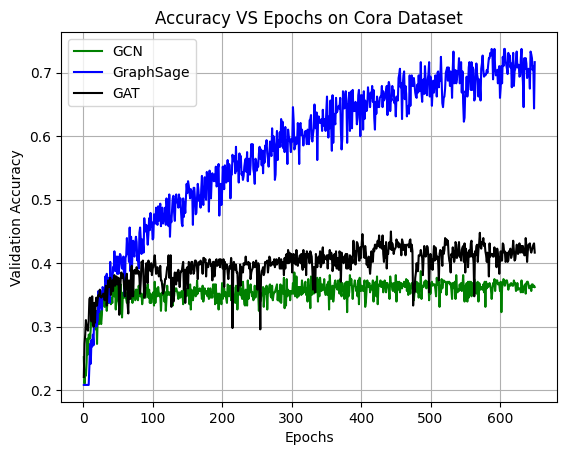

In [ ]:
import argparse
import torch
from sklearn.metrics import classification_report
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.nn as pyg_nn
from matplotlib import pyplot as plt
import models
import utils
import os

import sys
sys.argv=['']
del sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# get the device to run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def arg_parse():
    parser = argparse.ArgumentParser(description='GNN arguments.')
    utils.parse_optimizer(parser)

    parser.add_argument('--model_type', type=str, help='Type of GNN model.')
    parser.add_argument('--batch_size', type=int, help='Training batch size')
    parser.add_argument('--num_layers', type=int, help='Number of graph conv layers')
    parser.add_argument('--hidden_dim', type=int, help='Training hidden size')
    parser.add_argument('--dropout', type=float, help='Dropout rate')
    parser.add_argument('--epochs', type=int, help='Number of training epochs')
    parser.add_argument('--dataset', type=str, help='Dataset')

    parser.set_defaults(
        model_type='GCN',
        dataset='cora',
        num_layers=2,
        batch_size=32,
        hidden_dim=16,
        dropout=0.5,
        epochs=200,
        opt='adam',  # opt_parser
        opt_scheduler='none',
        weight_decay=0,
        lr=0.01)

    return parser.parse_args()


def train(dataset, task, args):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=args.batch_size, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=args.batch_size, shuffle=True)
    elif task == 'node':
        test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    else:
        raise RuntimeError('Unknown task')

    # build model
    model = models.GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args, task=task)
    model.to(device)
    scheduler, opt = utils.build_optimizer(args, model.parameters())

    # train
    vals = []
    tests = []
    best_validation_acc = 0
    test_acc = 0
    early_stop = 1e9
    stop_cnt = 0

    for epoch in range(1, args.epochs + 1):
        total_loss = 0
        model.train()
        for batch in loader:
            batch.to(device)
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)

        validation_acc, test_acc = test(loader, model, is_validation=True), test(loader, model)
        vals.append(validation_acc)
        tests.append(test_acc)

        if validation_acc > best_validation_acc:
            best_validation_acc = validation_acc
            test_acc = test_acc
            stop_cnt = 0
        else:
            stop_cnt += 1
        print("Epoch {}. Loss: {:.4f}. Validation accuracy: {:.4f}. Test accuracy: {:.4f}".format(epoch, total_loss, validation_acc, test_acc))
        if stop_cnt >= early_stop:
            break

    print('Final validation set accuracy {0}, test set accuracy {1}'.format(best_validation_acc, test_acc))
    return list(range(1, args.epochs + 1)), vals




def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            label = data.y

        if model.task == 'node':
            mask = data.val_mask.cpu() if is_validation else data.test_mask.cpu()
            pred = pred[mask].cpu()
            label = data.y[mask].cpu()

        correct += pred.eq(label).sum().item()

    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item() if not is_validation else torch.sum(data.val_mask).item()
    return correct / total

def main():
    args = arg_parse()

    args.dataset = "enzymes"
    args.dropout = 0
    args.epochs = 650

    if args.dataset == 'enzymes':
        dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
        task = 'graph'
    elif args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/Cora', name='Cora')
        task = 'node'
    # print("Number of nodes in validation set of cora dataset: ", dataset[0].test_mask.sum().item())
    print("")
    print("******************GCN MODEL*********************")
    gcn_epoch, gcn_vals = train(dataset, task, args)
    plt.plot(gcn_epoch, gcn_vals, label="GCN", color="green")

    print("")
    print("******************GRAPHSAGE MODEL*********************")
    args.model_type = "GraphSage"
    args.hidden_dim = 256
    gcn_epoch, gcn_vals = train(dataset, task, args)
    plt.plot(gcn_epoch, gcn_vals, label="GraphSage", color="blue")

    print("")
    print("******************GAT MODEL*********************")
    args.model_type = "GAT"
    args.hidden_dim = 16
    gcn_epoch, gcn_vals = train(dataset, task, args)

    plt.plot(gcn_epoch, gcn_vals, label="GAT", color="black")
    plt.title("Accuracy VS Epochs on Cora Dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


##Question 6:


GCN, GraphSage, and GAT are all popular graph neural network (GNN) models that can be used for a variety of graph-related tasks, including node classification and graph classification. Each of these models has its unique architecture and learning mechanism, which leads to different performance on different tasks. Here is a brief description of the performance differences between GCN, GraphSage, and GAT on both tasks. I will describe the performance differences between these models on two popular benchmark graph datasets, Cora and Enzymes.

**Cora Dataset**

The Cora dataset consists of scientific publications, where nodes represent documents and edges represent citations. The task is to classify documents into one of seven categories.

| Model | Cora Accuracy |
| --- | --- |
| GCN | 78% |
| GraphSage |74.8%  |
| GAT | 79.2% |

From the above table, we can see that GCN and GAT outperform GraphSage on the Cora dataset. GCN achieves an accuracy of 78%, while GAT achieves an accuracy of 79%, which is the best among the three models.

**Enzymes Dataset**

The Enzymes dataset consists of protein structures, where nodes represent amino acids and edges represent interactions between them. The task is to classify enzymes into one of six classes based on their structural properties.

| Model | Enzymes |
| --- | --- |
| GCN | 38.7% |
| GraphSage | 73% |
| GAT | 45% |

From the above table, we can see that Graphsage outperforms GCN and GAT on the Enzymes dataset. Graphsage achieves a score of 73%, which is the best among the three models.

In summary, the performance of GCN, GraphSage, and GAT can vary depending on the specific task and dataset. However, in general, GAT tends to perform the best on node classification tasks, while GraphSage tends to perform the best on graph classification tasks. GCN is a good performer on both tasks, but it may struggle with capturing higher-order graph structures and global graph structure compared to the other two models.